In [28]:
import pygplates
import glob
import sys
sys.path.append('/Users/Simon/GIT/gplates-web/django/GWS/utils/')
from create_gpml import create_gpml_healpix_mesh,create_gpml_regular_long_lat_mesh
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
import numpy as np

import paleogeography as pg

%matplotlib inline



basedir = '/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma'

time = 53 #396
sampling = 0.5

rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % basedir,
                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % basedir])

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,time)


# rasterise points using default environment list 
pg_points = pg.rasterise_paleogeography(pg_dir,rotation_model,time,sampling=sampling)


['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_53Ma/lm_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_53Ma/sm_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
[]
no features of type i


In [10]:
deep_ocean_features = []
for feature in pg_points:
    if feature.get_shapefile_attribute('Layer') is None:
        deep_ocean_features.append(feature)


In [11]:
MODELDIR = '/Applications/GPlates-2.0.0/SampleData/FeatureCollections/'
RotFile_List = ['%s/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot' % MODELDIR]
GPML_List = ['%s/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz' % MODELDIR,\
             '%s/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz' % MODELDIR,\
             '%s/DynamicPolygons/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz' % MODELDIR]

#####################################
rotation_model = pygplates.RotationModel(RotFile_List)
topology_features = pygplates.FeatureCollection()
for file in GPML_List:
    topology_feature = pygplates.FeatureCollection(file)
    topology_features.add(topology_feature)
#'''

resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)



In [24]:

def find_distance_to_nearest_ridge(resolved_topologies,point_features,fill_value=5000.):
    
    all_point_distance_to_ridge = []
    all_point_lats = []
    all_point_lons = []

    for topology in resolved_topologies:
        plate_id = topology.get_resolved_feature().get_reconstruction_plate_id()
        print plate_id

        # Section to isolate the mid-ocean ridge segments that bound the current plate
        mid_ocean_ridges_on_plate = []
        for shared_boundary_section in shared_boundary_sections:

            if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('MidOceanRidge'):
                for shared_subsegment in shared_boundary_section.get_shared_sub_segments():
                    sharing_resolved_topologies = shared_subsegment.get_sharing_resolved_topologies()
                    for resolved_polygon in sharing_resolved_topologies:
                        if resolved_polygon.get_feature().get_reconstruction_plate_id() == plate_id:
                            mid_ocean_ridges_on_plate.append(shared_subsegment.get_resolved_geometry())
                            #print 'here'


        point_distance_to_ridge = []
        point_lats = []
        point_lons = []

        for point_feature in point_features:

            for points in point_feature.get_geometries():
                for point in points:

                    if topology.get_resolved_geometry().is_point_in_polygon(point):

                        if len(mid_ocean_ridges_on_plate)>0:

                            min_distance_to_ridge = None

                            for ridge in mid_ocean_ridges_on_plate:
                                distance_to_ridge = pygplates.GeometryOnSphere.distance(point,ridge,min_distance_to_ridge)

                                if distance_to_ridge is not None:
                                    min_distance_to_ridge = distance_to_ridge

                            point_distance_to_ridge.append(min_distance_to_ridge*pygplates.Earth.mean_radius_in_kms)
                            point_lats.append(point.to_lat_lon()[0])
                            point_lons.append(point.to_lat_lon()[1])

                        else:

                            point_distance_to_ridge.append(fill_value)
                            point_lats.append(point.to_lat_lon()[0])
                            point_lons.append(point.to_lat_lon()[1])
                            
        all_point_distance_to_ridge.extend(point_distance_to_ridge)
        all_point_lats.extend(point_lats)
        all_point_lons.extend(point_lons)
        
        
    return all_point_lons,all_point_lats,all_point_distance_to_ridge


    #        for ridge in mid_ocean_ridges_on_plate:
    #            plt.plot(ridge.to_lat_lon_array()[:,1],ridge.to_lat_lon_array()[:,0])

    #        plt.scatter(point_lons,point_lats,c=point_distance_to_ridge,edgecolors='',vmin=0,vmax=8000,cmap=plt.cm.gnuplot_r)

    #plt.colorbar()         
    #plt.show()


In [31]:
def age2depth(age_array,model='GDH1'):

    if model is 'GDH1':
        paleodepth = 2600. + 365. * np.sqrt(age_array)
        paleodepth[age_array>=20.] = 5651 - 2473*np.exp(-0.0278*age_array[age_array>=20.])
        paleodepth = -paleodepth
    
    elif model is 'Crosby':
        paleodepth = -2527. - (336. * np.sqrt(age_array))  
    
    else:
        print 'unknown depth model'
        
    return paleodepth
    
    

802
301
102
406
409
901
317
201
804
529
609
780
801
501
738
701
308
307
836
304
224
904
833
608
922
880
101
902
918


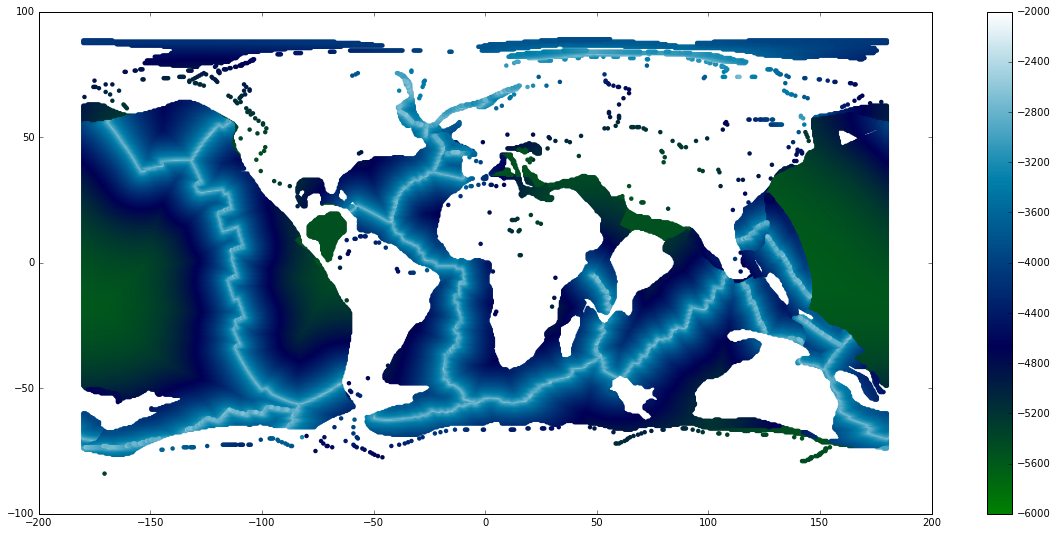

In [37]:
pX,pY,pZ = find_distance_to_nearest_ridge(resolved_topologies,deep_ocean_features)

age = np.array(pZ) / 50.

pdepth = age2depth(age)


plt.figure(figsize=(20,9))

#for ridge in mid_ocean_ridges_on_plate:
#    plt.plot(ridge.to_lat_lon_array()[:,1],ridge.to_lat_lon_array()[:,0])

plt.scatter(pX,pY,c=pdepth,edgecolors='',vmin=-6000,vmax=-2000,cmap=plt.cm.ocean)

plt.colorbar()         
plt.show()


In [34]:
print pdepth


[-5502.76888662 -5571.48056809 -5571.4323594  ..., -4706.5899579
 -4693.28741924 -4680.08594005]
